# Tasks (Read prediction)

Since we don’t have access to the test labels, we’ll need to simulate validation/test sets of our own. So, let’s split the training data (‘train Interactions.csv.gz’) as follows:

(1) Reviews 1-190,000 for training

(2) Reviews 190,001-200,000 for validation

(3) Upload to Kaggle for testing only when you have a good model on the validation set. This will save you time (since Kaggle can take several minutes to return results), and prevent you from exceeding your daily submission limit.

In [1]:
# ============ Environment Setup ============
# ignore the warnings
import warnings
warnings.filterwarnings("ignore")

# import some packages
import gzip
import random
import pandas as pd
from tqdm.notebook import tqdm
from collections import defaultdict

def splitDataset(datapath):
    """
    Split the training data (‘train Interactions.csv.gz’) as follows:
    (1) Reviews 1-190,000 for training
    (2) Reviews 190,001-200,000 for validation
    :param datapath:
    :return: train, valid as dataframe
    """
    f = gzip.open(datapath, 'rt')
    data = pd.read_csv(f)
    train, valid = data[:190001], data[190001:]
    return data, train, valid

data, train, valid = splitDataset("./data/train_Interactions.csv.gz")

## Question 1

Although we have built a validation set, it only consists of positive samples. For this task we also need examples of user/item pairs that weren’t read. For each entry (user,book) in the validation set, sample a negative entry by randomly choosing a book that user hasn’t read. Evaluate the performance (accuracy) of the baseline model on the validation set you have built (1 mark).

In [2]:
def sampleNegative(data, train, valid):
    """
    For each entry (user,book) in the validation set, sample a negative entry
        by randomly choosing a book that user hasn’t read.
    :param train:
    :param valid:
    :return:
    """
    valid['read'] = 1
    NegValid = valid

    userBookDict = {}
    print("Preprocessing Data userBookDict ...")
    for index, row in tqdm(data.iterrows()):
        if row['userID'] not in userBookDict:
            userBookDict[row['userID']] = {row['bookID']}
        else:
            userBookDict[row['userID']].add(row['bookID'])

    for index, row in tqdm(valid.iterrows()):
        samNegBookID = random.sample(set(data['bookID']) - userBookDict[row['userID']], 1)[0]
        NegValid = NegValid.append({'userID': row['userID'], 'bookID': samNegBookID, 'rating': 0, 'read':0}, ignore_index=True)

    return NegValid, userBookDict 

In [3]:
def baselineOnValidation():
    random.seed(5583)
    data, train, valid = splitDataset("./data/train_Interactions.csv.gz")
    print("Sampling Negative samples ...")
    valid, _ = sampleNegative(data, train, valid)

    bookCount = defaultdict(int)
    totalRead = 0

    print('Training ...')
    for index, row in tqdm(train.iterrows()):
        bookCount[row['bookID']] += 1
        totalRead += 1

    mostPopular = [(bookCount[x], x) for x in bookCount]
    mostPopular.sort()
    mostPopular.reverse()

    return1 = set()
    count = 0
    for ic, i in mostPopular:
        count += ic
        return1.add(i)
        if count > totalRead / 2:
            break

    print('Evaluating ...')
    correct = 0
    for index, row in tqdm(valid.iterrows()):
        if row['bookID'] in return1:
            correct += (row['read'] != 0)
        else:
            correct += (row['read'] == 0)
    
    print('Accuracy on Validation set is %.3f' % (correct/len(valid)))

baselineOnValidation()

Sampling Negative samples ...
Preprocessing Data userBookDict ...



Training ...



Evaluating ...



Accuracy on Validation set is 0.646


## Question 2

The existing ‘read prediction’ baseline just returns True if the item in question is ‘popular,’ using a threshold of the 50th percentile of popularity (totalRead/2). Assuming that the ‘non-read’ test examples are a random sample of user-book pairs, this threshold may not be the best one. See if you can find a better threshold and report its performance on your validatin set (1 mark).

Sampling Negative samples ...
Preprocessing Data userBookDict ...



Training ...
Evaluating on threshold 1 ...
Evaluating on threshold 2 ...
Evaluating on threshold 3 ...
Evaluating on threshold 4 ...
Evaluating on threshold 5 ...
Evaluating on threshold 6 ...
Evaluating on threshold 7 ...
Evaluating on threshold 8 ...
Evaluating on threshold 9 ...
Evaluating on threshold 10 ...


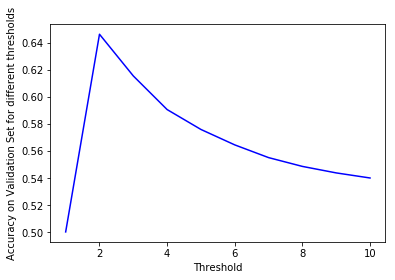

In [11]:
import matplotlib.pyplot as plt

def baselineOnValidation():
    random.seed(5583)
    data, train, valid = splitDataset("./data/train_Interactions.csv.gz")
    print("Sampling Negative samples ...")
    valid, _ = sampleNegative(data, train, valid)
    
    acc = []
    thresholds = list(range(1, 11))
    
    bookCount = defaultdict(int)
    totalRead = 0

    print('Training ...')
    for index, row in train.iterrows():
        bookCount[row['bookID']] += 1
        totalRead += 1

    mostPopular = [(bookCount[x], x) for x in bookCount]
    mostPopular.sort()
    mostPopular.reverse()

    for threshold in thresholds:
        return1 = set()
        count = 0
        for ic, i in mostPopular:
            count += ic
            return1.add(i)
            if count > totalRead / threshold:
                break

        print('Evaluating on threshold %d ...' % threshold)
        correct = 0
        for index, row in valid.iterrows():
            if row['bookID'] in return1:
                correct += (row['read'] != 0)
            else:
                correct += (row['read'] == 0)

        acc.append(correct/len(valid))

    plt.plot(thresholds, acc, 'b-')
    plt.xlabel('Threshold')
    plt.ylabel('Accuracy on Validation Set for different thresholds')
    plt.show()
    
baselineOnValidation()

As we can see, the best accuracy on validation set was achieved at threshold around $1.9$. And the accuracy is around $0.647$.

## Question 3

A stronger baseline than the one provided might make use of the Jaccard similarity (or another similarity metric). Given a pair (u, b) in the validation set, consider all training items b′ that user u has read. For each, compute the Jaccard similarity between b and b', i.e., users (in the training set) who have read b and users who have read b'. Predict as ‘read’ if the maximum of these Jaccard similarities exceeds a threshold (you may choose the threshold that works best). Report the performance on your validation set (1 mark).

In [5]:
random.seed(5583)
data, train, valid = splitDataset("./data/train_Interactions.csv.gz")
print("Sampling Negative samples ...")
valid, _ = sampleNegative(data, train, valid)

userReadBook, BookwasRead = {}, {}
for index, row in tqdm(train.iterrows()):
    if row['userID'] not in userReadBook:
        userReadBook[row['userID']] = {row['bookID']}
    else:
        userReadBook[row['userID']].add(row['bookID'])
    if row['bookID'] not in BookwasRead:
        BookwasRead[row['bookID']] = {row['userID']}
    else:
        BookwasRead[row['bookID']].add(row['userID'])

Sampling Negative samples ...
Preprocessing Data userBookDict ...


Evaluating on threshold 0.500 ...



Evaluating on threshold 0.250 ...



Evaluating on threshold 0.125 ...



Evaluating on threshold 0.062 ...



Evaluating on threshold 0.031 ...



Evaluating on threshold 0.016 ...



Evaluating on threshold 0.008 ...



Evaluating on threshold 0.004 ...



Evaluating on threshold 0.002 ...


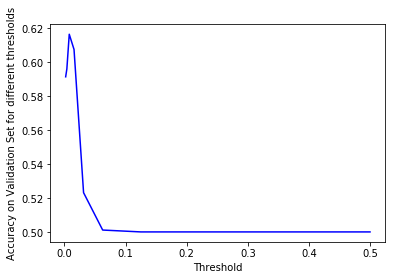

In [6]:
def Jaccard(s1, s2):
    numer = len(s1.intersection(s2))
    denom = len(s1.union(s2))
    return numer / denom

thresholds = [1/2**i for i in range(1, 10)]
acc = []
for threshold in thresholds:
    print('Evaluating on threshold %.3f ...' % threshold)
    correct = 0
    for index, row in tqdm(valid.iterrows()):
        userReads = userReadBook[row['userID']]
        jac = []
        for book in userReads:
            if row['bookID'] not in BookwasRead:
                jac.append(0)
            else:
                jac.append(Jaccard(BookwasRead[row['bookID']], BookwasRead[book]))
                
        if max(jac) > threshold:
            correct += (row['read'] != 0)
        else:
            correct += (row['read'] == 0)
    
    acc.append(correct/len(valid))

plt.plot(thresholds, acc, 'b-')
plt.xlabel('Threshold')
plt.ylabel('Accuracy on Validation Set for different thresholds')
plt.show()

In [7]:
print('threshold %.3f, accuracy %.3f' % (thresholds[acc.index(max(acc))], max(acc)))

threshold 0.008, accuracy 0.616


## Question 4

Improve the above predictor by incorporating both a Jaccard-based threshold and a popularity based threshold. Report the performance on your validation set (1 mark).

Simply Use a "and" operation for ensemble model.

In [8]:
# preprocessing
random.seed(5583)
data, train, valid = splitDataset("./data/train_Interactions.csv.gz")
print("Sampling Negative samples ...")
valid, _ = sampleNegative(data, train, valid)

userReadBook, BookwasRead = {}, {}
for index, row in tqdm(train.iterrows()):
    if row['userID'] not in userReadBook:
        userReadBook[row['userID']] = {row['bookID']}
    else:
        userReadBook[row['userID']].add(row['bookID'])
    if row['bookID'] not in BookwasRead:
        BookwasRead[row['bookID']] = {row['userID']}
    else:
        BookwasRead[row['bookID']].add(row['userID'])

Sampling Negative samples ...
Preprocessing Data userBookDict ...


In [30]:
def ensemble(threshold_pop = 1.9, threshold_jac = 0.008):
    bookCount = defaultdict(int)
    totalRead = 0

    print('Training ...')
    for index, row in train.iterrows():
        bookCount[row['bookID']] += 1
        totalRead += 1

    mostPopular = [(bookCount[x], x) for x in bookCount]
    mostPopular.sort()
    mostPopular.reverse()

    return1 = set()
    count = 0
    for ic, i in mostPopular:
        count += ic
        return1.add(i)
        if count > totalRead / threshold_pop:
            break
    
    print('Evaluating ...')
    correct = 0
    for index, row in tqdm(valid.iterrows()):
        userReads = userReadBook[row['userID']]
        jac = []
        for book in userReads:
            if row['bookID'] not in BookwasRead:
                jac.append(0)
            else:
                jac.append(Jaccard(BookwasRead[row['bookID']], BookwasRead[book]))

        if max(jac) > threshold_jac and row['bookID'] in return1:
            correct += (row['read'] != 0)
        else:
            correct += (row['read'] == 0)

    return correct/len(valid)
    
print("Accuracy is %.3f" % ensemble())

Training ...
Evaluating ...



Accuracy is 0.650


If we use the best thresholds from the single popularity and Jaccard method, the accuracy is 0.650. However, since in the ensemble model, we simply do a "and" operation, we should properly lower the thresholds.

###  Tune on Popularity Threshold

In [36]:
threshold_pops = [i/10 for i in range(10, 20)]
acc = []
for threshold_pop in threshold_pops:
    acc.append(ensemble(threshold_pop, threshold_jac = 0.008))

Training ...
Evaluating ...



Training ...
Evaluating ...



Training ...
Evaluating ...



Training ...
Evaluating ...



Training ...
Evaluating ...



Training ...
Evaluating ...



Training ...
Evaluating ...



Training ...
Evaluating ...



Training ...
Evaluating ...



Training ...
Evaluating ...


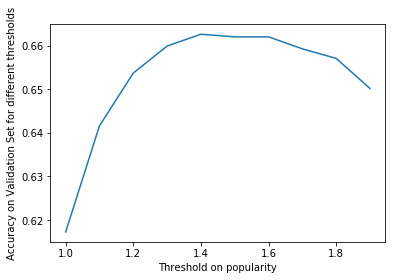

In [37]:
plt.plot(threshold_pops, acc)
plt.xlabel('Threshold on popularity')
plt.ylabel('Accuracy on Validation Set for different thresholds')
plt.show()

The best accuracy was achieved at threshold 1.4 as 0.663.

In [38]:
max(acc)

0.6626162616261626

### Tune on Jaccard Threshold

In [45]:
threshold_jacs = [i/10000 for i in range(50, 100, 10)]
acc = []
for threshold_jac in threshold_jacs:
    acc.append(ensemble(threshold_pop=1.4, threshold_jac=threshold_jac))

Training ...
Evaluating ...



Training ...
Evaluating ...



Training ...
Evaluating ...



Training ...
Evaluating ...



Training ...
Evaluating ...


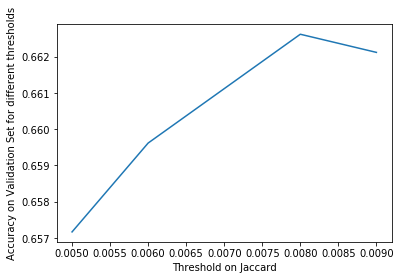

In [46]:
plt.plot(threshold_jacs, acc)
plt.xlabel('Threshold on Jaccard')
plt.ylabel('Accuracy on Validation Set for different thresholds')
plt.show()

According to the previous experiments, the best results 0.663 are achieved at the popularity threshold = 1.4, Jaccard threshold = 0.008.

## Question 5

To run our model on the test set, we’ll have to use the files ‘pairs Read.txt’ to find the reviewerID/itemID pairs about which we have to make predictions. Using that data, run the above model and upload your solution to Kaggle. Tell us your Kaggle user name (1 mark). If you’ve already uploaded a better solution to Kaggle, that’s fine too!

In [47]:
threshold_pop = 1.4
threshold_jac = 0.008

bookCount = defaultdict(int)
totalRead = 0

print('Training ...')
for index, row in train.iterrows():
    bookCount[row['bookID']] += 1
    totalRead += 1

mostPopular = [(bookCount[x], x) for x in bookCount]
mostPopular.sort()
mostPopular.reverse()

return1 = set()
count = 0
for ic, i in mostPopular:
    count += ic
    return1.add(i)
    if count > totalRead / threshold_pop:
        break

predictions = open("predictions_Read.txt", 'w')
for l in open("./data/pairs_Read.txt"):
    if l.startswith("userID"):
        # header
        predictions.write(l)
        continue
    u, b = l.strip().split('-')
    userReads = userReadBook[u]
    jac = []
    for book in userReads:
        if b not in BookwasRead:
            jac.append(0)
        else:
            jac.append(Jaccard(BookwasRead[b], BookwasRead[book]))

    if max(jac) > threshold_jac and b in return1:
        predictions.write(u + '-' + b + ",1\n")
    else:
        predictions.write(u + '-' + b + ",0\n")

predictions.close()

Training ...


### Kaggle

User name: shihanran

Display name: Shihan Ran

Email: sran@ucsd.edu

Public Leaderboard Score: 0.67466

# Tasks (Rating prediction)

Let’s start by building our training/validation sets much as we did for the first task. This time building a validation set is more straightforward: you can simply use part of the data for validation, and do not need to randomly sample non-read users/books.

## Question 9

Fit a predictor of the form

$$\text { rating (user, item ) } \simeq \alpha+\beta_{\text {user }}+\beta_{\text {item }}$$

by fitting the mean and the two bias terms as described in the lecture notes. Use a regularization parameter of $\lambda = 1$. Report the MSE on the validation set (1 mark).

In [53]:
import scipy
import scipy.optimize
import numpy as np

def prediction(user, item):
    return alpha + userBiases[user] + itemBiases[item]

def MSE(predictions, labels):
    differences = [(x-y)**2 for x,y in zip(predictions,labels)]
    return sum(differences) / len(differences)

def unpack(theta):
    global alpha
    global userBiases
    global itemBiases
    alpha = theta[0]
    userBiases = dict(zip(users, theta[1:nUsers+1]))
    itemBiases = dict(zip(items, theta[1+nUsers:]))
    
def cost(theta, labels, lamb):
    unpack(theta)
    predictions = [prediction(d['userID'], d['bookID']) for index, d in train.iterrows()]
    cost = MSE(predictions, labels)
    print("MSE = " + str(cost))
    for u in userBiases:
        cost += lamb*userBiases[u]**2
    for i in itemBiases:
        cost += lamb*itemBiases[i]**2
    return cost

def derivative(theta, labels, lamb):
    unpack(theta)
    N = len(train)
    dalpha = 0
    dUserBiases = defaultdict(float)
    dItemBiases = defaultdict(float)
    for index, d in train.iterrows():
        u,i = d['userID'], d['bookID']
        pred = prediction(u, i)
        diff = pred - d['rating']
        dalpha += 2/N*diff
        dUserBiases[u] += 2/N*diff
        dItemBiases[i] += 2/N*diff
    for u in userBiases:
        dUserBiases[u] += 2*lamb*userBiases[u]
    for i in itemBiases:
        dItemBiases[i] += 2*lamb*itemBiases[i]
    dtheta = [dalpha] + [dUserBiases[u] for u in users] + [dItemBiases[i] for i in items]
    return np.array(dtheta)

### Training 

In [54]:
lamb = 1
data, train, valid = splitDataset("./data/train_Interactions.csv.gz")

ratingMean = train['rating'].mean()
alpha = ratingMean

labels = train['rating']

userBiases = defaultdict(float)
itemBiases = defaultdict(float)

users = list(set(train['userID']))
items = list(set(train['bookID']))
nUsers = len(users)
nItems = len(items)

scipy.optimize.fmin_l_bfgs_b(cost, [alpha] + [0.0]*(nUsers+nItems),
                             derivative, args = (labels, lamb))

MSE = 1.4735439815452338
MSE = 1.4560896560389294
MSE = 1.4733864367918064
MSE = 1.473386434421149


(array([ 3.89708841e+00,  9.39450287e-05,  3.06462740e-05, ...,
        -1.74937858e-05,  3.89145254e-05, -1.19408114e-04]),
 1.473465196550704,
 {'grad': array([-2.47029336e-08, -3.42086976e-09, -1.74216486e-09, ...,
         -7.99313594e-09, -8.92116090e-09, -2.32554776e-08]),
  'task': b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL',
  'funcalls': 4,
  'nit': 2,
  'warnflag': 0})

### Validating

In [55]:
predictions = []
for index, d in valid.iterrows():
    u, i = d['userID'], d['bookID']
    if u in userBiases and i in itemBiases:
        predictions.append(prediction(u, i))
    else:
        predictions.append(0)

print("MSE %.3f" % MSE(predictions, valid['rating']))

MSE 1.491


## Question 10

Report the user and book IDs that have the largest and smallest values of $\beta$ (1 mark).

In [59]:
print("max user: %s , max value: %f" % (max(userBiases, key=userBiases.get), max(userBiases.values())))
print("max book: %s , max value: %f" % (max(itemBiases, key=itemBiases.get), max(itemBiases.values())))
print("min user: %s , min value: %f" % (min(userBiases, key=userBiases.get), min(userBiases.values())))
print("min book: %s , min value: %f" % (min(itemBiases, key=itemBiases.get), min(itemBiases.values())))

max user: u92864068 , max value: 0.000404
max book: b76915592 , max value: 0.000829
min user: u11591742 , min value: -0.001580
min book: b57299824 , min value: -0.000272


## Question 11

Find a better value of λ using your validation set. Report the value you chose, its MSE, and upload your solution to Kaggle by running it on the test data (1 mark).

### Tune on Lambda

#### Training

In [ ]:
lamb = 10**(-5)

def training(lamb):
    scipy.optimize.fmin_l_bfgs_b(cost, [alpha] + [0.0]*(nUsers+nItems),
                             derivative, args = (labels, lamb))
    
training(lamb)

In [74]:
lamb = 2*10**(-5)

def training(lamb):
    scipy.optimize.fmin_l_bfgs_b(cost, [alpha] + [0.0]*(nUsers+nItems),
                             derivative, args = (labels, lamb))
    
training(lamb)

MSE = 1.4832822467543116
MSE = 2.2774077819725242
MSE = 1.4733803095939564
MSE = 1.4732216116948278
MSE = 1.4725872844004562
MSE = 1.4700574040585836
MSE = 1.46005674405923
MSE = 1.4219558859536154
MSE = 1.0709100510026317
MSE = 1.1353667138062993
MSE = 1.0165601239612587
MSE = 0.9958361836255681
MSE = 0.958628708879125
MSE = 0.9456710724181053
MSE = 0.940360705198549
MSE = 0.9369120019287528
MSE = 0.9330258079843778
MSE = 0.9287915309290408
MSE = 0.9272107583190305
MSE = 0.9275681784630906
MSE = 0.9260959826878737
MSE = 1.0449432130774279
MSE = 0.9260944677265066
MSE = 0.9262261597070357
MSE = 0.9263431791924667
MSE = 0.9262840858001393
MSE = 0.9260195665750545
MSE = 0.9258423786552941
MSE = 0.9257710824567681
MSE = 0.925664913414827
MSE = 0.9256628584235027
MSE = 0.9256270715837497
MSE = 0.925645960656846
MSE = 0.925673372856432
MSE = 0.9256467166548477
MSE = 0.9256586008480103
MSE = 0.9256656647869687
MSE = 0.9256646978287322
MSE = 0.9256610351358464
MSE = 0.9256615363700421
MSE = 0

In [75]:
predictions = []
for index, d in valid.iterrows():
    u, i = d['userID'], d['bookID']
    if u in userBiases and i in itemBiases:
        predictions.append(prediction(u, i))
    else:
        predictions.append(0)

print("MSE %.3f" % MSE(predictions, valid['rating']))

MSE 1.109


#### Validating

In [63]:
predictions = []
for index, d in valid.iterrows():
    u, i = d['userID'], d['bookID']
    if u in userBiases and i in itemBiases:
        predictions.append(prediction(u, i))
    else:
        predictions.append(0)

print("MSE %.3f" % MSE(predictions, valid['rating']))

MSE 1.111


#### Predicting on Test

In [77]:
predictions = open("predictions_Rating.txt", 'w')
for l in open("./data/pairs_Rating.txt"):
    if l.startswith("userID"):
        #header
        predictions.write(l)
        continue
    u, i = l.strip().split('-')
    if u in userBiases and i in itemBiases:
        predictions.write(u + '-' + i + ',' + str(prediction(u, i)) + '\n')
    else:
        predictions.write(u + '-' + i + ',' + str(0) + '\n')

predictions.close()

Finally, we got MSE=1.14702 on test set.